In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np

In [26]:
import networkx as nx

def create_city_network():
    """"
    A grid simplifies the creation of a road network while still allowing for realistic traffic patterns. By defining key areas, we can simulate traffic flow between various parts of the city. The event venue is centrally located to represent its significant impact on surrounding traffic.
    """
    G = nx.grid_2d_graph(10, 10)  # 10x10 grid
    # Relabel nodes to string identifiers
    G = nx.convert_node_labels_to_integers(G, label_attribute='pos')
    mapping = {node: f"node_{node}" for node in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    
    # Add edge attributes
    for u, v in G.edges():
        G[u][v]['length'] = 1  # Assume all roads have equal length
        G[u][v]['speed_limit'] = 50  # km/h
        G[u][v]['capacity'] = 100  # Maximum number of vehicles per hour
    
    # Define key locations
    event_venue = 'node_55'  # Central node
    residential_areas = ['node_0', 'node_9', 'node_90', 'node_99']  # Corners of the grid
    
    return G, event_venue, residential_areas


In [27]:
class TrafficParameters:
    """
    Using reported increases in traffic delays allows us to adjust our simulation to reflect realistic congestion levels during the event. Estimating the number of vehicles based on attendance figures helps us model the additional load on the road network.
    Data from here: https://www.streetlightdata.com/taylor-swift-traffic-trends-eras-tour/#:~:text=Vehicle%20Hours%20of%20Delay%20(VHD,delay%20hours%20at%20comparable%20times.
    """
    def __init__(self):
        # Event-specific parameters
        self.event_attendance = 45000  # Number of attendees
        self.average_vehicle_occupancy = 3  # People per vehicle
        self.event_vehicles = self.event_attendance / self.average_vehicle_occupancy
        
        # Traffic delay increases
        self.delay_increase = {
            'high': 3.15,  # 315% increase
            'average': 1.90,  # 90% increase
            'low': 0.32  # 32% increase
        }
        
        # Baseline traffic parameters
        self.base_traffic_flow = 1000  # Vehicles per hour
        self.peak_hour_factor = 1.5
        self.off_peak_hour_factor = 0.7


In [28]:
from mesa import Agent, Model
from mesa.time import RandomActivation

"""Agent Based Modelling allows for modeling individual behaviors and interactions, providing a detailed view of traffic dynamics. It's suitable for capturing the variability in driver behaviors and routes. The bad thing though is that it is computationally intensive

We implement it like this:
Vehicle Agent:
Attributes: Unique ID, origin, destination, current position, path, travel time.
Methods:
- calculate_route(): Determines the shortest path from origin to destination.
- step(): Moves the vehicle along the path, updates travel time, and accounts for congestion.
- Traffic Model:
- Manages the simulation environment.
- Handles the generation of vehicles (both background and event-related).
- Updates road conditions (e.g., congestion levels)."""

class VehicleAgent(Agent):
    def __init__(self, unique_id, model, origin, destination, purpose):
        super().__init__(unique_id, model)
        self.origin = origin
        self.destination = destination
        self.purpose = purpose
        self.path = self.calculate_route()
        self.current_edge = None
        self.travel_time = 0
        self.has_arrived = False
    
    def calculate_route(self):
        return nx.shortest_path(
            self.model.G,
            source=self.origin,
            target=self.destination,
            weight='length'
        )
    
    def step(self):
        if self.has_arrived or len(self.path) <= 1:
            self.has_arrived = True
            return
        
        current_node = self.path.pop(0)
        next_node = self.path[0]
        edge_data = self.model.G[current_node][next_node]
        
        # Calculate congestion
        edge_load = edge_data.get('load', 0)
        capacity = edge_data['capacity']
        congestion_factor = edge_load / capacity
        
        # Adjust travel time
        base_travel_time = edge_data['length'] / edge_data['speed_limit']
        adjusted_travel_time = base_travel_time * (1 + congestion_factor)
        self.travel_time += adjusted_travel_time
        
        # Update edge load
        edge_data['load'] = edge_load + 1
        
        # Check if arrived
        if next_node == self.destination:
            self.has_arrived = True



In [ ]:
class TrafficModel(Model):
    def __init__(self, params):
        self.schedule = RandomActivation(self)
        self.params = params
        self.G, self.event_venue, self.residential_areas = create_city_network()
        self.current_time = 0  # Simulation time in hours

        """
        -Background Traffic Generation:
        Vehicles are generated based on a Poisson process reflecting average traffic flow rates.
        Origins and destinations are randomly selected from residential and commercial areas.
        -Event Traffic Generation:
        Vehicles are generated leading up to the event start time.
        Origins are primarily residential areas, destinations are the event venue.
        Adjust the generation rate based on the expected arrival patterns of attendees.
        
        This is an article showing that the poisson distribution is useful for synthetic data mimicking real-world data
        Link: https://onlinelibrary.wiley.com/doi/10.1155/2012/408395
        """
    
    def generate_background_traffic(self):
        # Determine traffic flow rate based on time of day
        if 7 <= self.current_time < 9 or 17 <= self.current_time < 19:
            flow_rate = self.params.base_traffic_flow * self.params.peak_hour_factor
        else:
            flow_rate = self.params.base_traffic_flow * self.params.off_peak_hour_factor
        
        num_vehicles = np.random.poisson(flow_rate)
        for _ in range(num_vehicles):
            # origin, destination = random.sample(self.G.nodes(), 2)
            origin, destination = random.sample(list(self.G.nodes()), 2)

            vehicle = VehicleAgent(
                unique_id=self.next_id(),
                model=self,
                origin=origin,
                destination=destination,
                purpose='background'
            )
            self.schedule.add(vehicle)
    
    def generate_event_traffic(self):
        # Only generate event traffic during specific times
        if self.current_time == self.event_start_time - 2:
            num_vehicles = int(self.params.event_vehicles * 0.5)  # 50% arrive 2 hours early
        elif self.current_time == self.event_start_time - 1:
            num_vehicles = int(self.params.event_vehicles * 0.3)  # 30% arrive 1 hour early
        elif self.current_time == self.event_start_time:
            num_vehicles = int(self.params.event_vehicles * 0.2)  # 20% arrive at start time
        else:
            num_vehicles = 0
        
        for _ in range(num_vehicles):
            origin = random.choice(self.residential_areas)
            vehicle = VehicleAgent(
                unique_id=self.next_id(),
                model=self,
                origin=origin,
                destination=self.event_venue,
                purpose='event'
            )
            self.schedule.add(vehicle)

    def step(self):
        # Reset edge loads
        for u, v in self.G.edges():
            self.G[u][v]['load'] = 0
        
        # Generate traffic
        self.generate_background_traffic()
        self.generate_event_traffic()
        
        # Advance time
        self.current_time = (self.current_time + 1) % 24
        
        # Step agents
        self.schedule.step()
    
    


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect data from the model
def collect_data(model):
    data = []
    for vehicle in model.schedule.agents:
        if vehicle.has_arrived:
            data.append({
                'travel_time': vehicle.travel_time,
                'purpose': vehicle.purpose,
                'origin': vehicle.origin,
                'destination': vehicle.destination
            })
    return pd.DataFrame(data)

# Analyze average travel times
def analyze_travel_times(df):
    avg_travel_times = df.groupby('purpose')['travel_time'].mean()
    print(avg_travel_times)

# Function to visualize congestion
def plot_congestion(model):
    plt.figure(figsize=(8, 8))
    pos = {node: (int(node.split('_')[1]), int(node.split('_')[2])) for node in model.G.nodes()}
    edge_loads = [data['load'] for _, _, data in model.G.edges(data=True)]
    max_load = max(edge_loads) if max(edge_loads) > 0 else 1

    nx.draw(
        model.G, pos,
        with_labels=True,
        edge_color=edge_loads,
        edge_cmap=plt.cm.Reds,
        edge_vmin=0,
        edge_vmax=max_load,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        width=2
    )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_load))
    sm.set_array([])
    plt.colorbar(sm, label="Edge Load (Number of Vehicles)")
    plt.title(f"Traffic Congestion at Time {model.current_time}")
    plt.show()


In [ ]:
# Define simulation parameters
params = {
    'base_traffic_flow': 20,   # Number of background vehicles per step
    'event_vehicles': 50,      # Number of event vehicles generated during event times
    'event_times': [5, 6]      # Time steps when event traffic is generated
}

# Initialize the model
model = TrafficModel(params)

# Run the simulation and visualize results
for _ in range(10):
    model.step()
    plot_congestion(model)

# Collect and plot total load over time
df = pd.DataFrame(model.data_collector)
plt.figure()
plt.plot(df['time'], df['total_load'], marker='o')
plt.xlabel('Time Step')
plt.ylabel('Total Network Load')
plt.title('Total Traffic Load Over Time')
plt.grid(True)
plt.show()

/var/folders/k8/4ml9j7qd0wl8_r4dvk5rkmjm0000gn/T/ipykernel_99137/1284481792.py:3: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


AttributeError: 'TrafficModel' object has no attribute 'random'

# VERSION I AM WORKING ON RN

/var/folders/k8/4ml9j7qd0wl8_r4dvk5rkmjm0000gn/T/ipykernel_99137/510959094.py:61: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


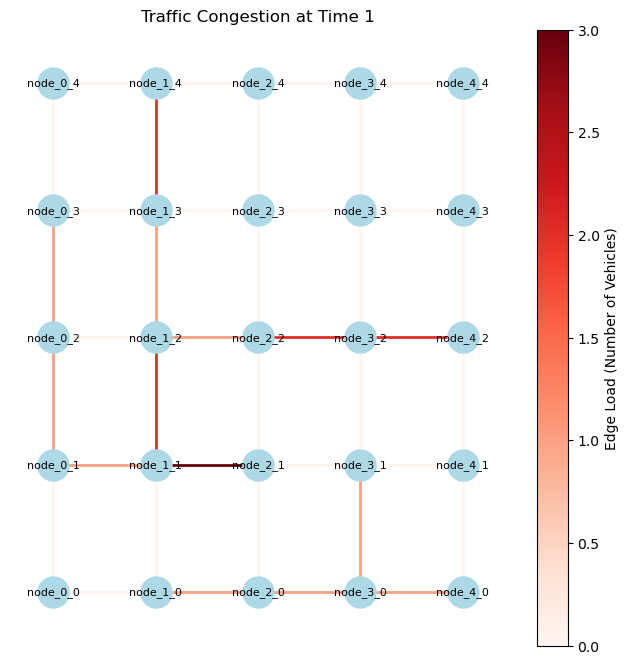

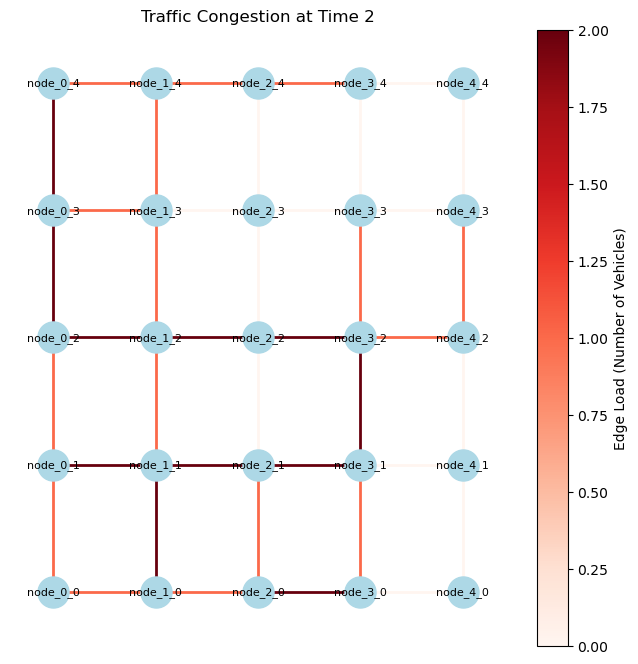

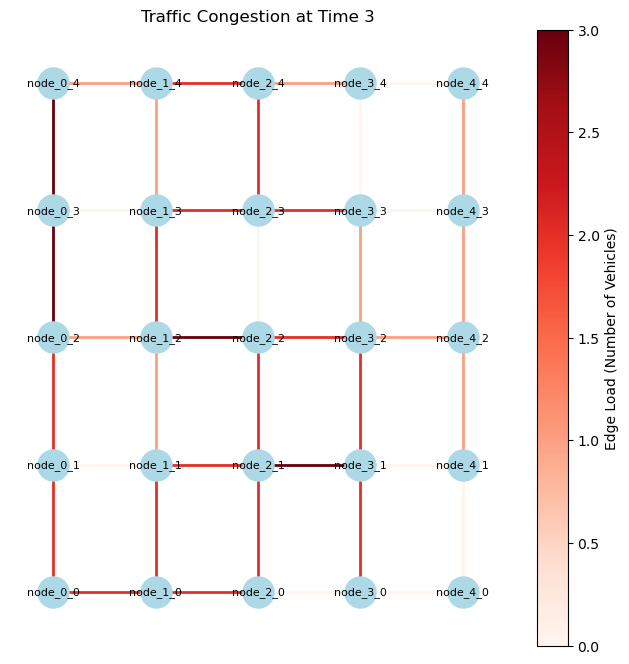

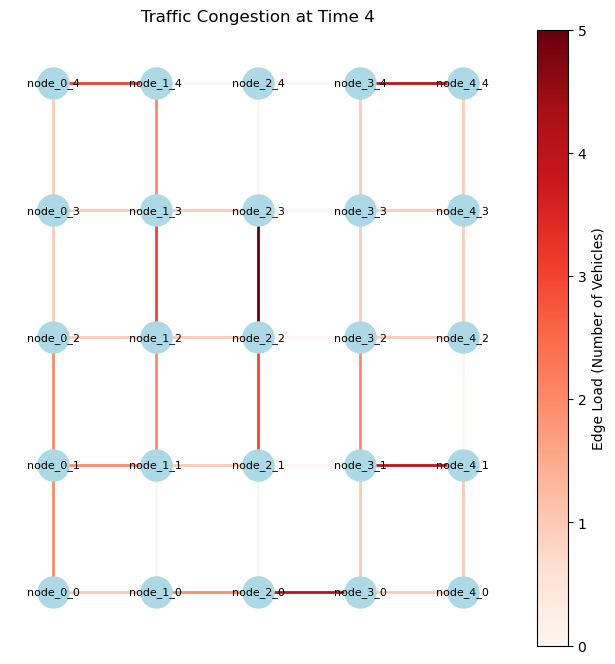

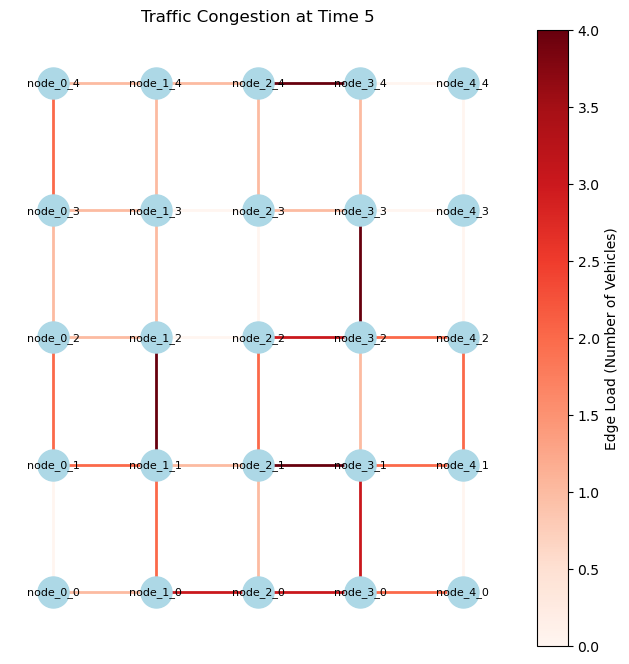

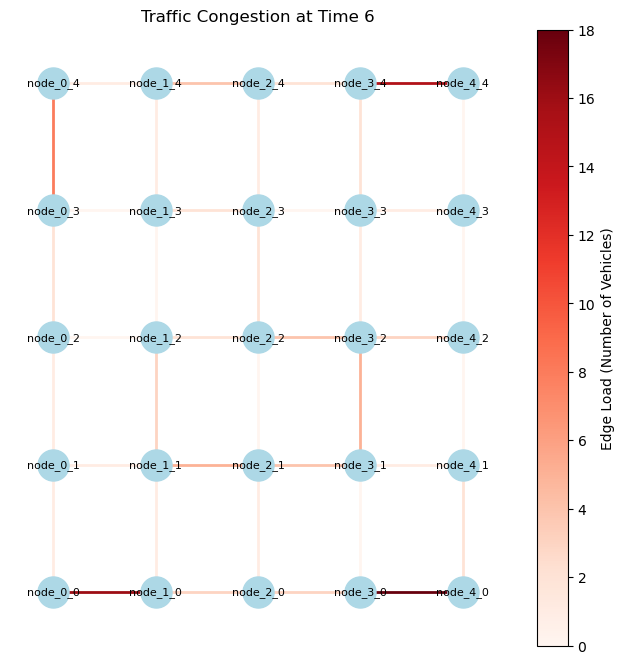

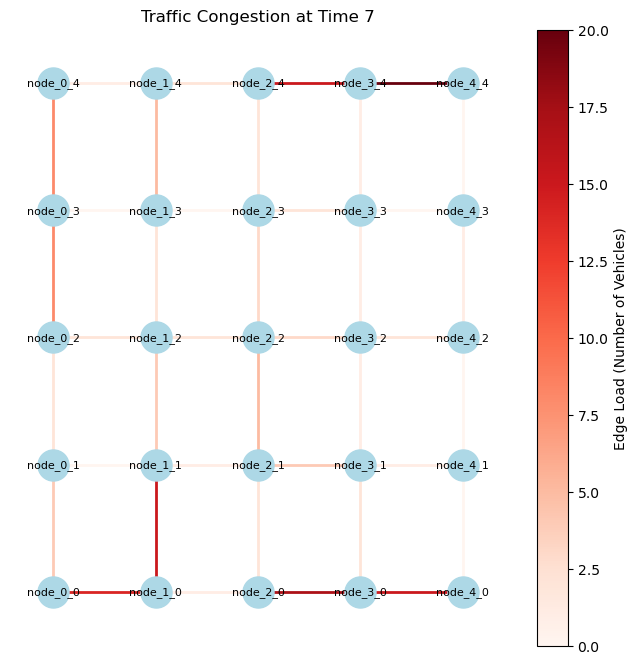

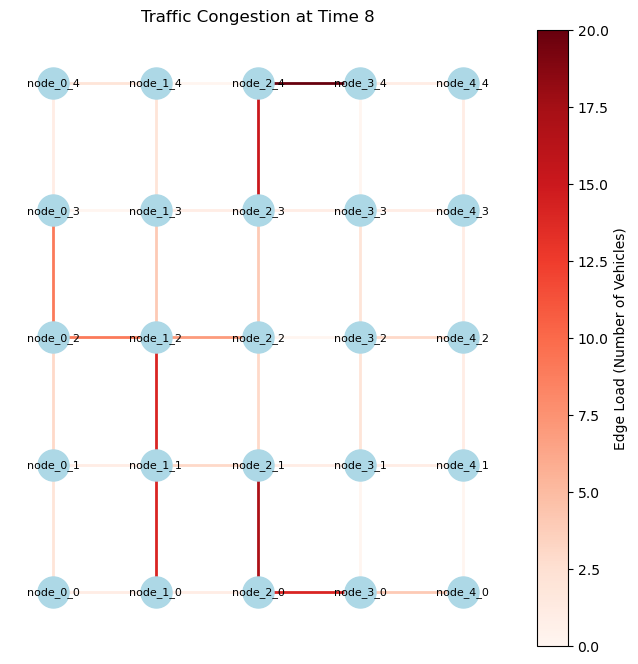

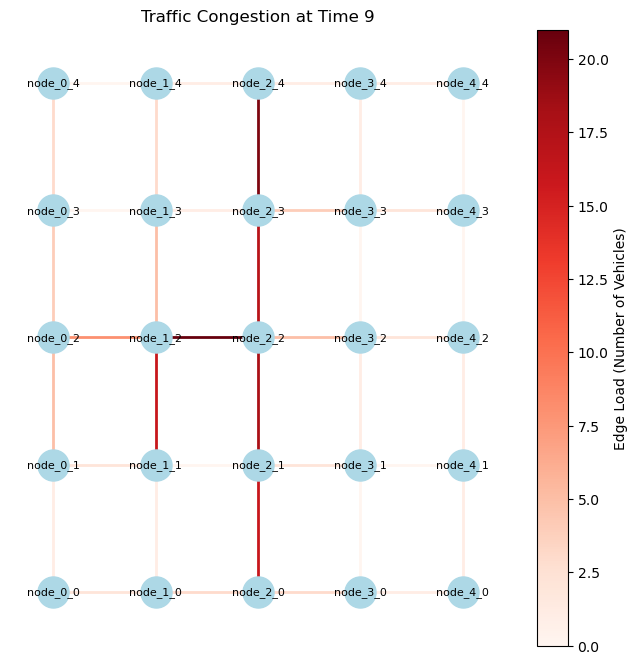

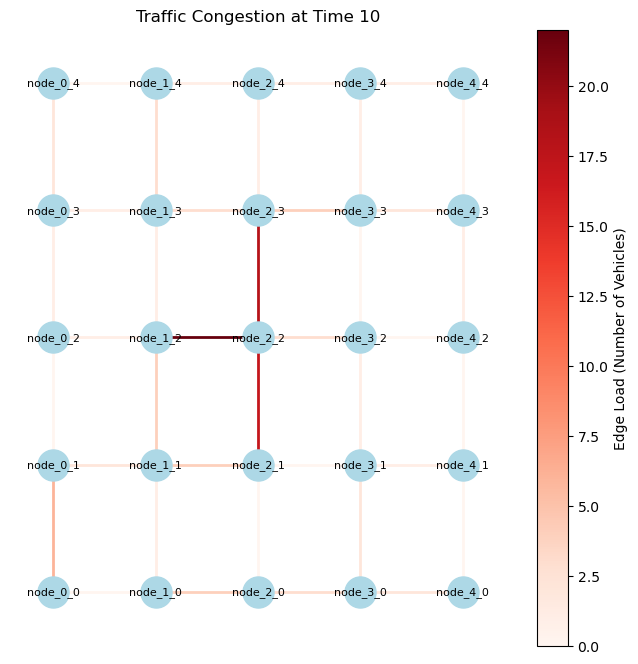

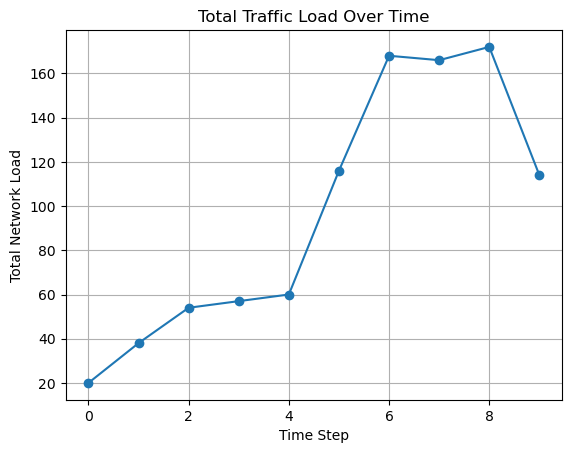

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np

# VehicleAgent class
class VehicleAgent(Agent):
    def __init__(self, model, origin, destination, purpose):
        super().__init__(model)
        self.origin = origin
        self.destination = destination
        self.purpose = purpose
        self.path = self.calculate_route()
        self.has_arrived = False
        self.travel_time = 0

    def calculate_route(self):
        try:
            return nx.shortest_path(
                self.model.G,
                source=self.origin,
                target=self.destination,
                weight='length'
            )
        except nx.NetworkXNoPath:
            return []

    def step(self):
        if self.has_arrived or not self.path or len(self.path) <= 1:
            self.has_arrived = True
            return

        current_node = self.path.pop(0)
        next_node = self.path[0]
        edge_data = self.model.G[current_node][next_node]

        # Simulate travel and congestion
        edge_load = edge_data.get('load', 0)
        capacity = edge_data['capacity']
        congestion_factor = edge_load / capacity

        # Adjust travel time
        base_travel_time = edge_data['length'] / edge_data['speed_limit']
        adjusted_travel_time = base_travel_time * (1 + congestion_factor)
        self.travel_time += adjusted_travel_time

        # Update edge load
        edge_data['load'] = edge_load + 1

        if len(self.path) == 1:
            self.has_arrived = True

# TrafficModel class
class TrafficModel(Model):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.schedule = RandomActivation(self)
        self.G, self.event_venue, self.residential_areas = self.create_city_network()
        self.current_time = 0
        self.data_collector = []

    def create_city_network(self):
        G = nx.grid_2d_graph(5, 5)
        mapping = {node: f"node_{node[0]}_{node[1]}" for node in G.nodes()}
        G = nx.relabel_nodes(G, mapping)
        for u, v in G.edges():
            G[u][v].update({
                'length': 1,
                'speed_limit': 50,
                'capacity': 100,
                'load': 0
            })
        event_venue = 'node_2_2'
        residential_areas = ['node_0_0', 'node_0_4', 'node_4_0', 'node_4_4']
        return G, event_venue, residential_areas

    def generate_background_traffic(self):
        num_vehicles = self.params['base_traffic_flow']
        nodes_list = list(self.G.nodes())
        for _ in range(num_vehicles):
            origin, destination = random.sample(nodes_list, 2)
            vehicle = VehicleAgent(
                model=self,
                origin=origin,
                destination=destination,
                purpose='background'
            )
            self.schedule.add(vehicle)

    def generate_event_traffic(self):
        if self.current_time in self.params['event_times']:
            num_vehicles = self.params['event_vehicles']
            for _ in range(num_vehicles):
                origin = random.choice(self.residential_areas)
                vehicle = VehicleAgent(
                    model=self,
                    origin=origin,
                    destination=self.event_venue,
                    purpose='event'
                )
                self.schedule.add(vehicle)

    def step(self):
        # Reset edge loads
        for u, v in self.G.edges():
            self.G[u][v]['load'] = 0

        # Generate traffic
        self.generate_background_traffic()
        self.generate_event_traffic()

        # Step agents
        self.schedule.step()

        # Collect data
        self.collect_data()

        # Advance time
        self.current_time += 1

    def collect_data(self):
        total_load = sum([data['load'] for _, _, data in self.G.edges(data=True)])
        self.data_collector.append({
            'time': self.current_time,
            'total_load': total_load
        })

# Function to visualize congestion
def plot_congestion(model):
    fig, ax = plt.subplots(figsize=(8, 8))  # Use subplots to get fig and ax
    pos = {node: (int(node.split('_')[1]), int(node.split('_')[2])) for node in model.G.nodes()}
    edge_loads = [data['load'] for _, _, data in model.G.edges(data=True)]
    max_load = max(edge_loads) if max(edge_loads) > 0 else 1

    # Draw the network on the given axes
    nx.draw(
        model.G, pos,
        ax=ax,  # Pass the axes object here
        with_labels=True,
        edge_color=edge_loads,
        edge_cmap=plt.cm.Reds,
        edge_vmin=0,
        edge_vmax=max_load,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        width=2
    )

    # Create a ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_load))
    sm.set_array([])

    # Add the colorbar to the figure, specifying the axes
    fig.colorbar(sm, ax=ax, label="Edge Load (Number of Vehicles)")

    # Set the title using the axes object
    ax.set_title(f"Traffic Congestion at Time {model.current_time}")

    # Show the plot
    plt.show()



# Define simulation parameters
params = {
    'base_traffic_flow': 20,   # Number of background vehicles per step
    'event_vehicles': 50,      # Number of event vehicles generated during event times
    'event_times': [5, 6]      # Time steps when event traffic is generated
}

# Initialize the model
model = TrafficModel(params)

# Run the simulation and visualize results
for _ in range(10):
    model.step()
    plot_congestion(model)

# Collect and plot total load over time
df = pd.DataFrame(model.data_collector)
plt.figure()
plt.plot(df['time'], df['total_load'], marker='o')
plt.xlabel('Time Step')
plt.ylabel('Total Network Load')
plt.title('Total Traffic Load Over Time')
plt.grid(True)
plt.show()


In [37]:
import mesa
print(mesa.__version__)


3.0.3


/var/folders/k8/4ml9j7qd0wl8_r4dvk5rkmjm0000gn/T/ipykernel_99137/3943012177.py:69: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


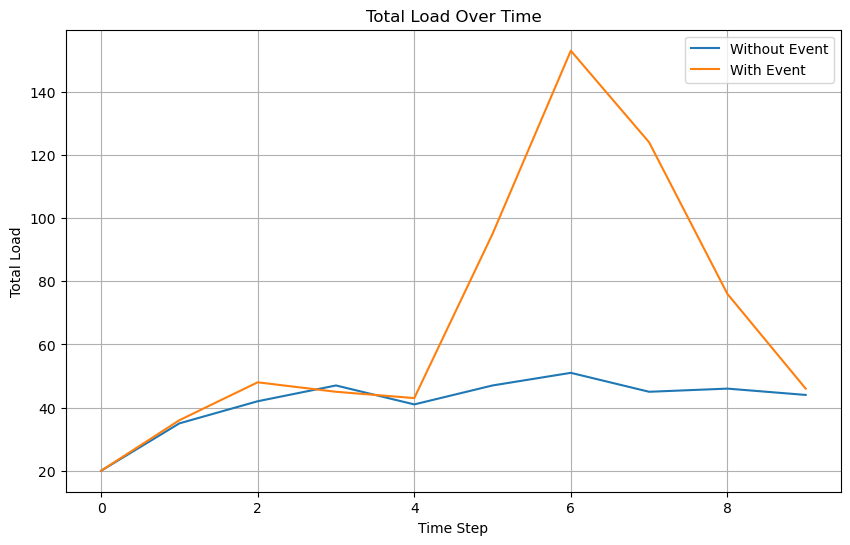

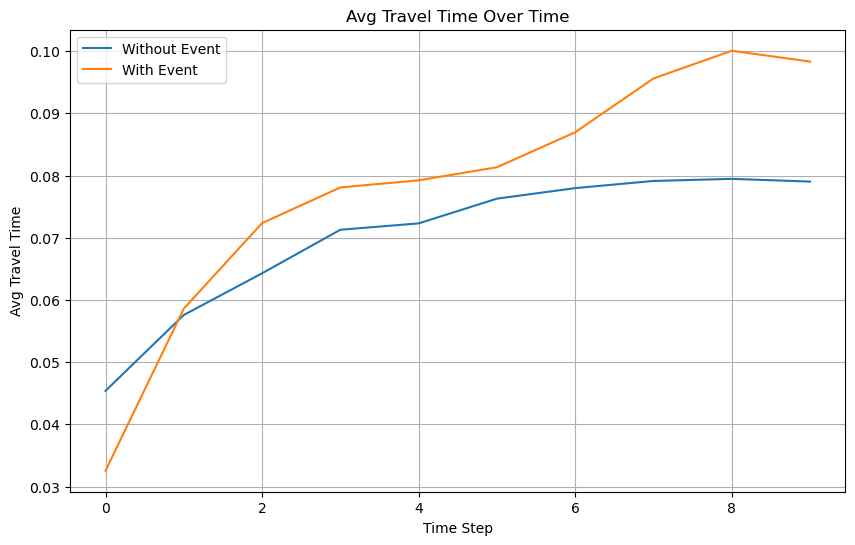

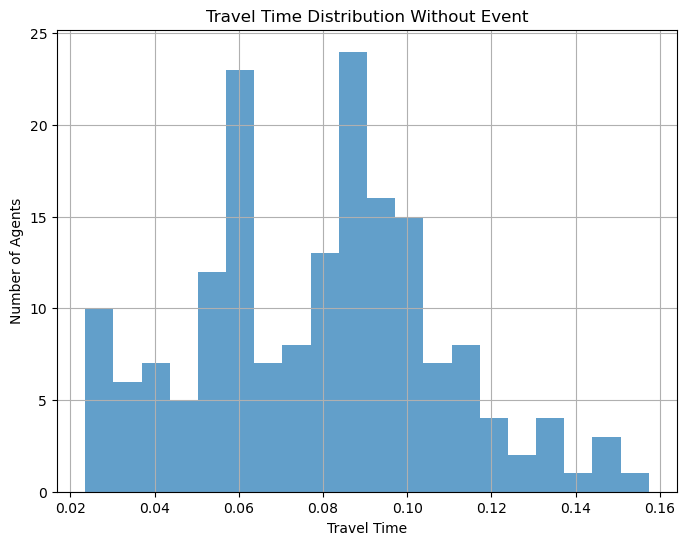

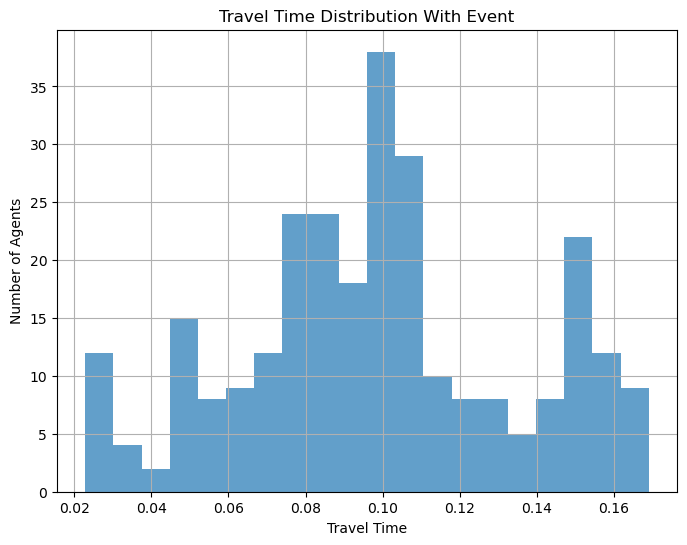

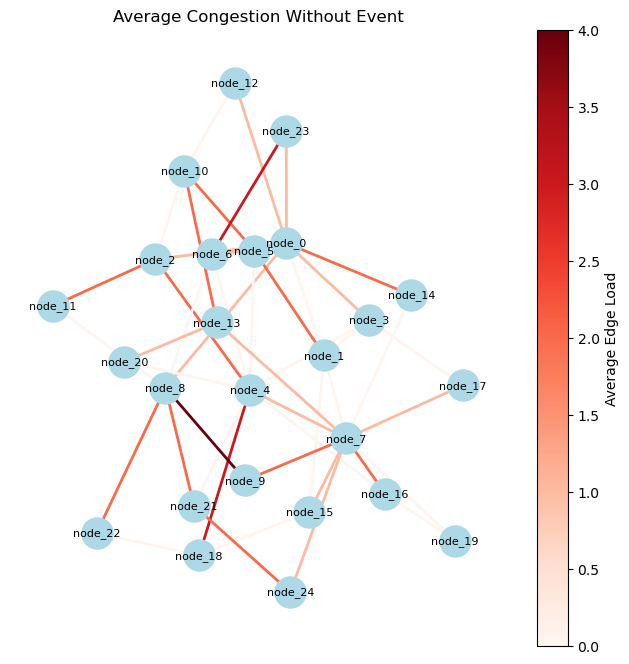

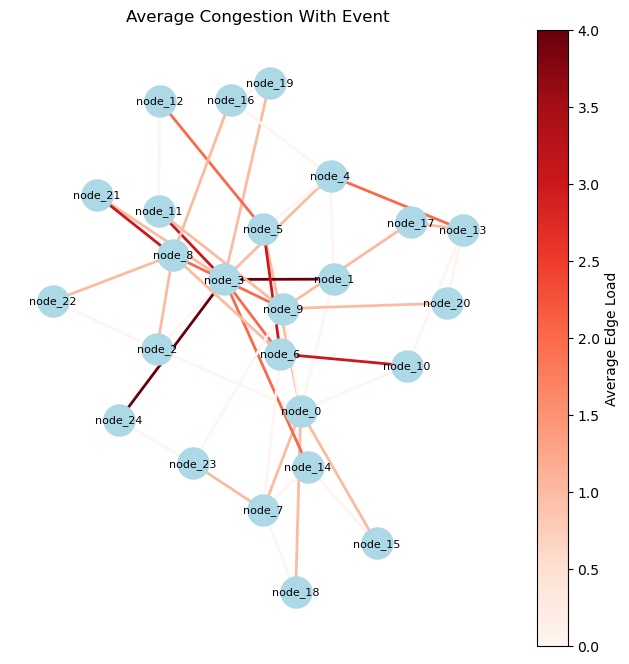

Communities detected: [['node_2', 'node_10', 'node_18', 'node_14', 'node_4', 'node_0', 'node_5', 'node_8', 'node_23', 'node_24', 'node_15', 'node_16', 'node_19', 'node_1', 'node_6', 'node_3', 'node_7', 'node_22', 'node_21'], ['node_11', 'node_13', 'node_20', 'node_9', 'node_17', 'node_12']]


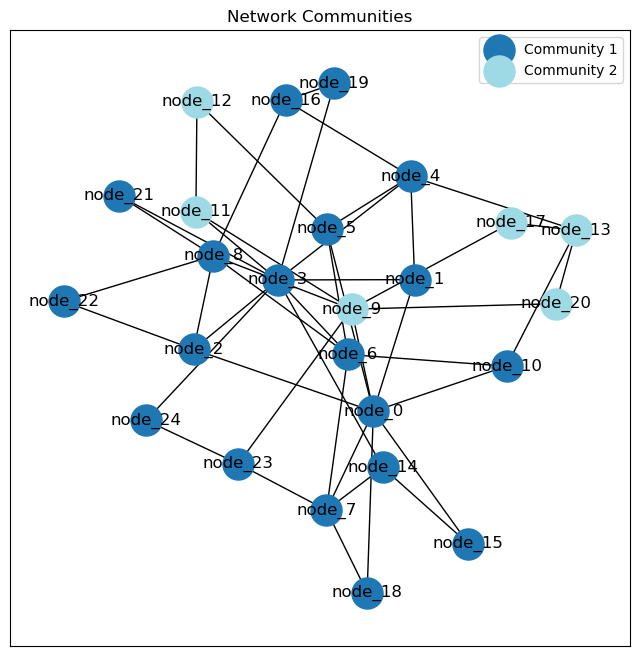

Congestion at Time 6 Without Event


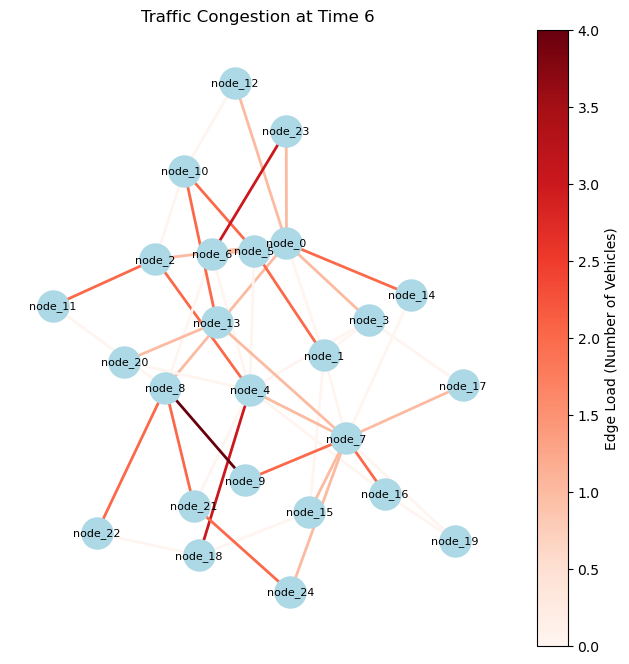

Congestion at Time 6 With Event


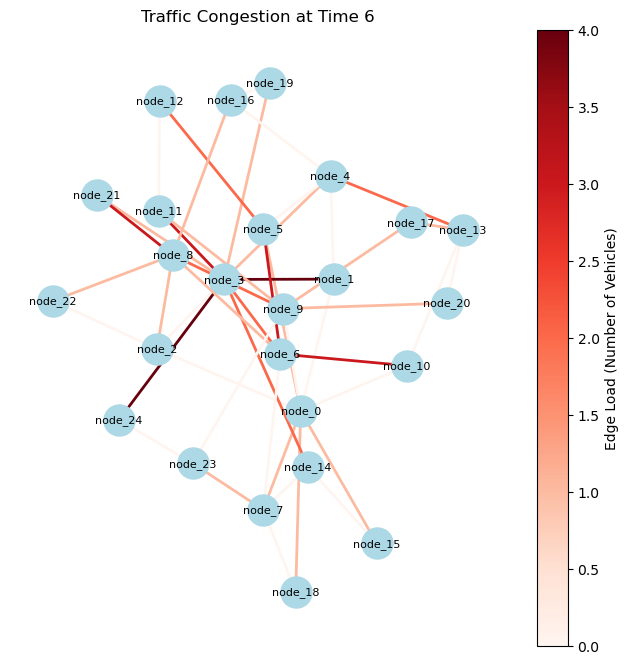

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np

# VehicleAgent class
class VehicleAgent(Agent):
    def __init__(self, model, origin, destination, purpose):
        super().__init__(model)
        self.origin = origin
        self.destination = destination
        self.purpose = purpose
        self.path = self.calculate_route()
        self.has_arrived = False
        self.travel_time = 0

    def calculate_route(self):
        try:
            return nx.shortest_path(
                self.model.G,
                source=self.origin,
                target=self.destination,
                weight='length'
            )
        except nx.NetworkXNoPath:
            return []

    def step(self):
        if self.has_arrived or not self.path or len(self.path) <= 1:
            self.has_arrived = True
            return

        current_node = self.path.pop(0)
        if len(self.path) == 0:
            self.has_arrived = True
            return
        next_node = self.path[0]
        edge_data = self.model.G.get_edge_data(current_node, next_node)

        if edge_data is None:
            self.has_arrived = True
            return

        # Simulate travel and congestion
        edge_load = edge_data.get('load', 0)
        capacity = edge_data['capacity']
        congestion_factor = edge_load / capacity

        # Adjust travel time
        base_travel_time = edge_data['length'] / edge_data['speed_limit']
        adjusted_travel_time = base_travel_time * (1 + congestion_factor)
        self.travel_time += adjusted_travel_time

        # Update edge load
        edge_data['load'] = edge_load + 1

        if len(self.path) == 1:
            self.has_arrived = True

# TrafficModel class
class TrafficModel(Model):
    def __init__(self, params, graph_type='grid'):
        super().__init__()
        self.params = params
        self.graph_type = graph_type
        self.schedule = RandomActivation(self)
        self.G, self.event_venue, self.residential_areas = self.create_city_network(graph_type=self.graph_type)
        self.current_time = 0
        self.data_collector = []

    def create_city_network(self, graph_type='grid'):
        if graph_type == 'grid':
            G = nx.grid_2d_graph(5, 5)
            mapping = {node: f"node_{node[0]}_{node[1]}" for node in G.nodes()}
            G = nx.relabel_nodes(G, mapping)
        elif graph_type == 'erdos_renyi':
            num_nodes = 25
            prob = 0.1  # Probability of edge creation
            G = nx.erdos_renyi_graph(num_nodes, prob)
            G = nx.convert_node_labels_to_integers(G)
            mapping = {node: f"node_{node}" for node in G.nodes()}
            G = nx.relabel_nodes(G, mapping)
        elif graph_type == 'barabasi_albert':
            num_nodes = 25
            m = 2  # Number of edges to attach from a new node to existing nodes
            G = nx.barabasi_albert_graph(num_nodes, m)
            G = nx.convert_node_labels_to_integers(G)
            mapping = {node: f"node_{node}" for node in G.nodes()}
            G = nx.relabel_nodes(G, mapping)
        elif graph_type == 'watts_strogatz':
            num_nodes = 25
            k = 4  # Each node is joined with k nearest neighbors
            prob = 0.1  # Probability of rewiring
            G = nx.watts_strogatz_graph(num_nodes, k, prob)
            G = nx.convert_node_labels_to_integers(G)
            mapping = {node: f"node_{node}" for node in G.nodes()}
            G = nx.relabel_nodes(G, mapping)
        else:
            raise ValueError("Unsupported graph type")

        # Add edge attributes
        for u, v in G.edges():
            G[u][v].update({
                'length': random.uniform(1, 3),
                'speed_limit': 50,
                'capacity': 100,
                'load': 0
            })

        # Define key locations (e.g., event venue, residential areas)
        # For simplicity, select random nodes
        nodes_list = list(G.nodes())
        event_venue = random.choice(nodes_list)
        residential_areas = random.sample(nodes_list, k=4)

        return G, event_venue, residential_areas

    def generate_background_traffic(self):
        num_vehicles = self.params['base_traffic_flow']
        nodes_list = list(self.G.nodes())
        for _ in range(num_vehicles):
            origin, destination = random.sample(nodes_list, 2)
            vehicle = VehicleAgent(
                model=self,
                origin=origin,
                destination=destination,
                purpose='background'
            )
            self.schedule.add(vehicle)

    def generate_event_traffic(self):
        if self.current_time in self.params['event_times']:
            num_vehicles = self.params['event_vehicles']
            for _ in range(num_vehicles):
                origin = random.choice(self.residential_areas)
                vehicle = VehicleAgent(
                    model=self,
                    origin=origin,
                    destination=self.event_venue,
                    purpose='event'
                )
                self.schedule.add(vehicle)

    def step(self):
        # Reset edge loads
        for u, v in self.G.edges():
            self.G[u][v]['load'] = 0

        # Generate traffic
        self.generate_background_traffic()
        self.generate_event_traffic()

        # Step agents
        self.schedule.step()

        # Collect data
        self.collect_data()

        # Advance time
        self.current_time += 1

    def collect_data(self):
        total_load = sum([data['load'] for _, _, data in self.G.edges(data=True)])
        arrived_agents = [agent for agent in self.schedule.agents if agent.has_arrived]
        if arrived_agents:
            avg_travel_time = np.mean([agent.travel_time for agent in arrived_agents])
        else:
            avg_travel_time = 0
        num_agents = len(self.schedule.agents)
        self.data_collector.append({
            'time': self.current_time,
            'total_load': total_load,
            'avg_travel_time': avg_travel_time,
            'num_agents': num_agents
        })

# Function to plot congestion
def plot_congestion(model):
    fig, ax = plt.subplots(figsize=(8, 8))
    # Use spring layout for better visualization
    pos = nx.spring_layout(model.G, seed=42)
    edge_loads = [model.G[u][v]['load'] for u, v in model.G.edges()]
    max_load = max(edge_loads) if max(edge_loads) > 0 else 1

    nx.draw(
        model.G, pos,
        ax=ax,
        with_labels=True,
        edge_color=edge_loads,
        edge_cmap=plt.cm.Reds,
        edge_vmin=0,
        edge_vmax=max_load,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        width=2
    )

    # Create a ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_load))
    sm.set_array([])

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, label="Edge Load (Number of Vehicles)")

    # Set the title
    ax.set_title(f"Traffic Congestion at Time {model.current_time}")
    plt.show()

# Function to plot metrics over time
def plot_metrics(df_no_event, df_with_event, metric):
    plt.figure(figsize=(10, 6))
    plt.plot(df_no_event['time'], df_no_event[metric], label='Without Event')
    plt.plot(df_with_event['time'], df_with_event[metric], label='With Event')
    plt.xlabel('Time Step')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot travel time distribution
def plot_travel_time_distribution(model, title):
    travel_times = [agent.travel_time for agent in model.schedule.agents if agent.has_arrived]
    plt.figure(figsize=(8, 6))
    plt.hist(travel_times, bins=20, alpha=0.7)
    plt.xlabel('Travel Time')
    plt.ylabel('Number of Agents')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Function to aggregate edge loads
def aggregate_edge_loads(model):
    edge_loads = {}
    for data in model.data_collector:
        for u, v, attr in model.G.edges(data=True):
            key = (u, v)
            load = attr['load']
            if key in edge_loads:
                edge_loads[key] += load
            else:
                edge_loads[key] = load
    # Average over time steps
    for key in edge_loads:
        edge_loads[key] /= len(model.data_collector)
    return edge_loads

# Function to plot aggregate congestion
def plot_aggregate_congestion(model, edge_loads, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.spring_layout(model.G, seed=42)
    edge_values = [edge_loads.get((u, v), 0) for u, v in model.G.edges()]
    max_load = max(edge_values) if max(edge_values) > 0 else 1

    nx.draw(
        model.G, pos,
        ax=ax,
        with_labels=True,
        edge_color=edge_values,
        edge_cmap=plt.cm.Reds,
        edge_vmin=0,
        edge_vmax=max_load,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        width=2
    )

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_load))
    sm.set_array([])

    fig.colorbar(sm, ax=ax, label="Average Edge Load")
    ax.set_title(title)
    plt.show()

# Function to detect and plot communities
def detect_communities(G):
    # Use the Girvan-Newman algorithm
    communities_generator = nx.community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    communities = [list(c) for c in top_level_communities]
    return communities

def plot_communities(G, communities, title):
    pos = nx.spring_layout(G, seed=42)
    colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
    fig, ax = plt.subplots(figsize=(8, 8))
    for idx, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=community,
                               node_color=[colors[idx]],
                               node_size=500,
                               ax=ax,
                               label=f'Community {idx+1}')
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    ax.set_title(title)
    ax.legend()
    plt.show()

# Function to compare congestion at a specific time step
def compare_congestion(model_no_event, model_with_event, time_step):
    # Set the models to the desired time step
    model_no_event.current_time = time_step
    model_with_event.current_time = time_step

    # Plot without event
    print(f"Congestion at Time {time_step} Without Event")
    plot_congestion(model_no_event)

    # Plot with event
    print(f"Congestion at Time {time_step} With Event")
    plot_congestion(model_with_event)

# Now, let's run the simulations and generate the plots

# Parameters without event
params_no_event = {
    'base_traffic_flow': 20,
    'event_vehicles': 0,       # No event vehicles
    'event_times': []
}
model_no_event = TrafficModel(params_no_event, graph_type='barabasi_albert')
for _ in range(10):
    model_no_event.step()
df_no_event = pd.DataFrame(model_no_event.data_collector)

# Parameters with event
params_with_event = {
    'base_traffic_flow': 20,
    'event_vehicles': 50,
    'event_times': [5, 6]
}
model_with_event = TrafficModel(params_with_event, graph_type='barabasi_albert')
for _ in range(10):
    model_with_event.step()
df_with_event = pd.DataFrame(model_with_event.data_collector)

# Plot metrics over time
plot_metrics(df_no_event, df_with_event, 'total_load')
plot_metrics(df_no_event, df_with_event, 'avg_travel_time')

# Plot travel time distribution
plot_travel_time_distribution(model_no_event, 'Travel Time Distribution Without Event')
plot_travel_time_distribution(model_with_event, 'Travel Time Distribution With Event')

# Aggregate edge loads and plot aggregate congestion
edge_loads_no_event = aggregate_edge_loads(model_no_event)
edge_loads_with_event = aggregate_edge_loads(model_with_event)

plot_aggregate_congestion(model_no_event, edge_loads_no_event, 'Average Congestion Without Event')
plot_aggregate_congestion(model_with_event, edge_loads_with_event, 'Average Congestion With Event')

# Detect and plot communities
communities = detect_communities(model_with_event.G)
print("Communities detected:", communities)
plot_communities(model_with_event.G, communities, 'Network Communities')

# Compare congestion at time step 6
compare_congestion(model_no_event, model_with_event, time_step=6)


# NEW Experiemnts

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/var/folders/k8/4ml9j7qd0wl8_r4dvk5rkmjm0000gn/T/ipykernel_52249/2489511089.py:72: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


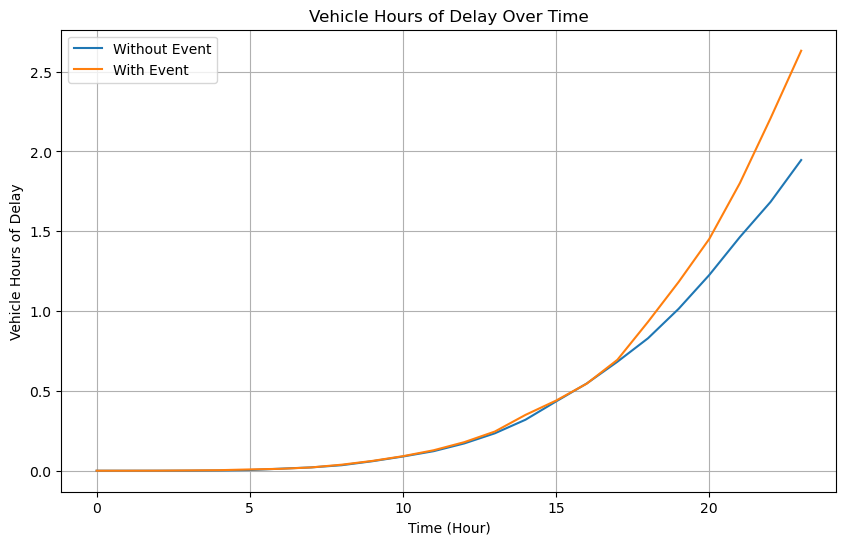

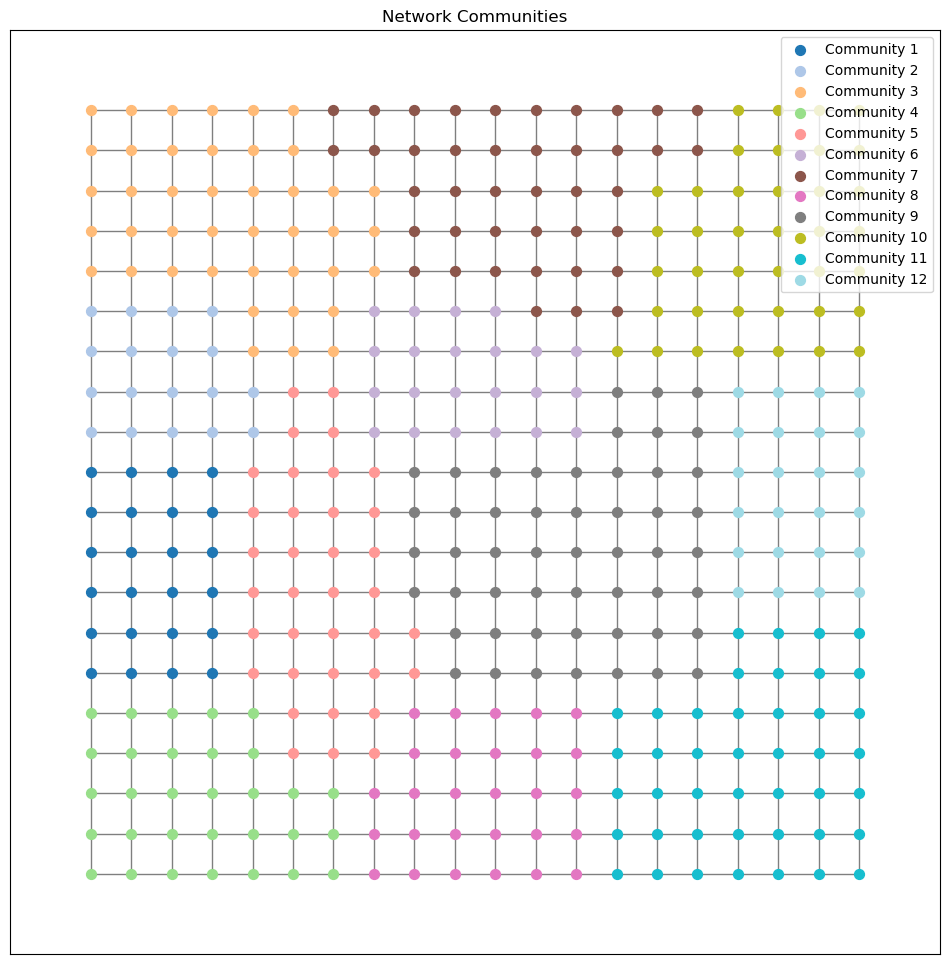

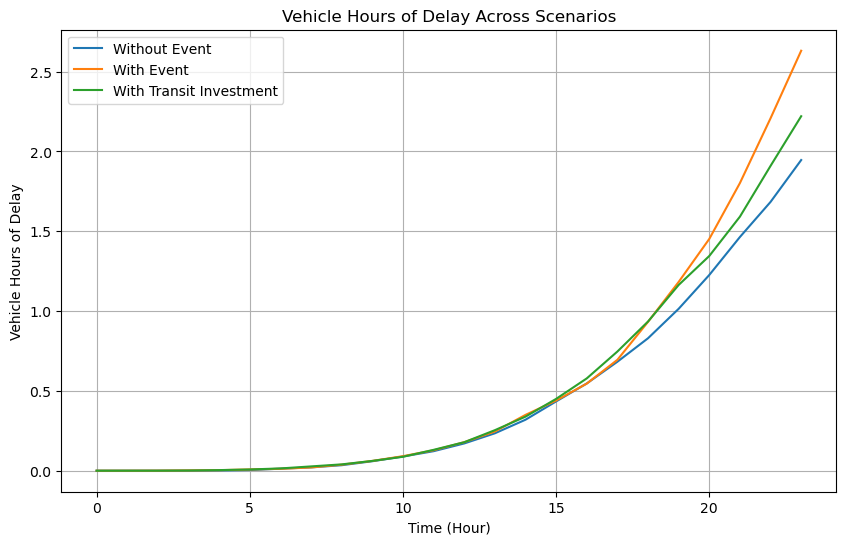

VHD increased by 7.59% during the event without transit investment.
VHD increased by 11.16% during the event with transit investment.


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np

# VehicleAgent class
class VehicleAgent(Agent):
    def __init__(self, model, origin, destination, purpose):
        super().__init__(model)
        self.origin = origin
        self.destination = destination
        self.purpose = purpose
        self.path = self.calculate_route()
        self.has_arrived = False
        self.travel_time = 0
        self.free_flow_time = 0
        self.delay = 0

    def calculate_route(self):
        try:
            return nx.shortest_path(
                self.model.G,
                source=self.origin,
                target=self.destination,
                weight='length'
            )
        except nx.NetworkXNoPath:
            return []

    def step(self):
        if self.has_arrived or not self.path or len(self.path) <= 1:
            self.has_arrived = True
            return

        current_node = self.path.pop(0)
        if len(self.path) == 0:
            self.has_arrived = True
            return
        next_node = self.path[0]
        edge_data = self.model.G.get_edge_data(current_node, next_node)

        if edge_data is None:
            self.has_arrived = True
            return

        # Simulate travel and congestion
        edge_load = edge_data.get('load', 0)
        capacity = edge_data['capacity']
        congestion_factor = edge_load / capacity

        # Adjust travel time
        base_travel_time = edge_data['length'] / edge_data['speed_limit']
        adjusted_travel_time = base_travel_time * (1 + congestion_factor)
        self.travel_time += adjusted_travel_time
        self.free_flow_time += edge_data['free_flow_time']
        self.delay += adjusted_travel_time - edge_data['free_flow_time']

        # Update edge load
        edge_data['load'] = edge_load + 1

        if len(self.path) == 1:
            self.has_arrived = True

# TrafficModel class
class TrafficModel(Model):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.schedule = RandomActivation(self)
        self.G, self.event_venue, self.residential_areas = self.create_city_network()
        self.current_time = 0
        self.data_collector = []

    def create_city_network(self):
        # Create a larger grid graph
        G = nx.grid_2d_graph(20, 20)
        # Assign positions to nodes
        pos = {(x, y): (x, y) for x, y in G.nodes()}
        nx.set_node_attributes(G, pos, 'pos')
        # Relabel nodes to string identifiers
        mapping = {node: f"node_{node[0]}_{node[1]}" for node in G.nodes()}
        G = nx.relabel_nodes(G, mapping)
        # Update positions after relabeling
        pos = {mapping[node]: coord for node, coord in pos.items()}
        nx.set_node_attributes(G, pos, 'pos')

        # Add edge attributes
        for u, v in G.edges():
            # First, set the attributes
            G[u][v]['length'] = random.uniform(1, 3)
            G[u][v]['speed_limit'] = 50
            G[u][v]['capacity'] = 1000
            G[u][v]['load'] = 0

            # Then, calculate 'free_flow_time' using the set values
            G[u][v]['free_flow_time'] = G[u][v]['length'] / G[u][v]['speed_limit']

        # Define key locations
        concert_venue = 'node_10_10'  # Central node as concert venue
        residential_areas = [
            'node_0_0', 'node_0_19', 'node_19_0', 'node_19_19',
            'node_0_10', 'node_10_0', 'node_19_10', 'node_10_19'
        ]

        return G, concert_venue, residential_areas

    def generate_background_traffic(self):
        num_vehicles = self.params['base_traffic_flow']
        nodes_list = list(self.G.nodes())
        for _ in range(num_vehicles):
            origin, destination = random.sample(nodes_list, 2)
            vehicle = VehicleAgent(
                model=self,
                origin=origin,
                destination=destination,
                purpose='background'
            )
            self.schedule.add(vehicle)

    def generate_event_traffic(self):
        if self.current_time in self.params['event_times']:
            num_vehicles = self.params['event_vehicles']
            for _ in range(num_vehicles):
                origin = random.choice(self.residential_areas)
                vehicle = VehicleAgent(
                    model=self,
                    origin=origin,
                    destination=self.event_venue,
                    purpose='event'
                )
                self.schedule.add(vehicle)

    def step(self):
        # Reset edge loads
        for u, v in self.G.edges():
            self.G[u][v]['load'] = 0

        # Generate traffic
        self.generate_background_traffic()
        self.generate_event_traffic()

        # Step agents
        self.schedule.step()

        # Collect data
        self.collect_data()

        # Advance time
        self.current_time += 1

    def collect_data(self):
        total_load = sum([data['load'] for _, _, data in self.G.edges(data=True)])
        arrived_agents = [agent for agent in self.schedule.agents if agent.has_arrived]
        if arrived_agents:
            avg_travel_time = np.mean([agent.travel_time for agent in arrived_agents])
            total_delay = sum([agent.delay for agent in arrived_agents])
        else:
            avg_travel_time = 0
            total_delay = 0
        num_agents = len(self.schedule.agents)
        self.data_collector.append({
            'time': self.current_time,
            'total_load': total_load,
            'avg_travel_time': avg_travel_time,
            'num_agents': num_agents,
            'total_delay': total_delay
        })

# Parameters without event
params_no_event = {
    'base_traffic_flow': 200,
    'event_vehicles': 0,       # No event vehicles
    'event_times': []
}
model_no_event = TrafficModel(params_no_event)
for _ in range(24):  # Simulate 24 hours
    model_no_event.step()
df_no_event = pd.DataFrame(model_no_event.data_collector)

# Parameters with event
params_with_event = {
    'base_traffic_flow': 200,
    'event_vehicles': 5000,    # Large number of event vehicles
    'event_times': [17, 18]    # Event occurs during peak hours
}
model_with_event = TrafficModel(params_with_event)
for _ in range(24):
    model_with_event.step()
df_with_event = pd.DataFrame(model_with_event.data_collector)

# Define event hours for VHD calculation
event_hours = params_with_event['event_times']

def plot_vhd(df_no_event, df_with_event):
    plt.figure(figsize=(10, 6))
    plt.plot(df_no_event['time'], df_no_event['total_delay'], label='Without Event')
    plt.plot(df_with_event['time'], df_with_event['total_delay'], label='With Event')
    plt.xlabel('Time (Hour)')
    plt.ylabel('Vehicle Hours of Delay')
    plt.title('Vehicle Hours of Delay Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_vhd(df_no_event, df_with_event)

# Community detection using NetworkX's built-in Louvain method
def detect_communities(G):
    communities = nx.community.louvain_communities(G, seed=42)
    return [list(c) for c in communities]

def plot_communities(G, communities, title):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
    fig, ax = plt.subplots(figsize=(12, 12))
    for idx, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=communities[idx],
                               node_color=[colors[idx]],
                               node_size=50,
                               ax=ax,
                               label=f'Community {idx+1}')
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    # Optionally, you can remove labels for clarity in large graphs
    # nx.draw_networkx_labels(G, pos, ax=ax, font_size=6)
    ax.set_title(title)
    ax.legend()
    plt.show()

# Detect and plot communities
communities = detect_communities(model_with_event.G)
plot_communities(model_with_event.G, communities, 'Network Communities')

# Parameters with public transit investment
params_with_transit = {
    'base_traffic_flow': 200,
    'event_vehicles': 1000,    # Reduced event vehicles
    'event_times': [17, 18]
}
model_with_transit = TrafficModel(params_with_transit)
for _ in range(24):
    model_with_transit.step()
df_with_transit = pd.DataFrame(model_with_transit.data_collector)

# Plot VHD for all scenarios
plt.figure(figsize=(10, 6))
plt.plot(df_no_event['time'], df_no_event['total_delay'], label='Without Event')
plt.plot(df_with_event['time'], df_with_event['total_delay'], label='With Event')
plt.plot(df_with_transit['time'], df_with_transit['total_delay'], label='With Transit Investment')
plt.xlabel('Time (Hour)')
plt.ylabel('Vehicle Hours of Delay')
plt.title('Vehicle Hours of Delay Across Scenarios')
plt.legend()
plt.grid(True)
plt.show()

# VHD during event hours
event_hours = params_with_event['event_times']  # Ensure event_hours is defined
vhd_no_event = df_no_event[df_no_event['time'].isin(event_hours)]['total_delay'].mean()
vhd_with_event = df_with_event[df_with_event['time'].isin(event_hours)]['total_delay'].mean()
vhd_with_transit = df_with_transit[df_with_transit['time'].isin(event_hours)]['total_delay'].mean()

increase_with_event = ((vhd_with_event - vhd_no_event) / vhd_no_event) * 100
increase_with_transit = ((vhd_with_transit - vhd_no_event) / vhd_no_event) * 100

print(f"VHD increased by {increase_with_event:.2f}% during the event without transit investment.")
print(f"VHD increased by {increase_with_transit:.2f}% during the event with transit investment.")


# Viz with OpenMAp

In [2]:
import osmnx as ox

# TrafficModel class
class TrafficModel(Model):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.schedule = RandomActivation(self)
        self.G, self.event_venue, self.residential_areas = self.create_city_network()
        self.current_time = 0
        self.data_collector = []

    def create_city_network(self):
        # Create a larger grid graph
        G = nx.grid_2d_graph(20, 20)
        # Assign positions to nodes
        pos = {(x, y): (x, y) for x, y in G.nodes()}
        nx.set_node_attributes(G, pos, 'pos')
        # Relabel nodes to string identifiers
        mapping = {node: f"node_{node[0]}_{node[1]}" for node in G.nodes()}
        G = nx.relabel_nodes(G, mapping)
        # Update positions after relabeling
        pos = {mapping[node]: coord for node, coord in pos.items()}
        nx.set_node_attributes(G, pos, 'pos')

        # Add edge attributes
        for u, v in G.edges():
            # First, set the attributes
            G[u][v]['length'] = random.uniform(1, 3)
            G[u][v]['speed_limit'] = 50
            G[u][v]['capacity'] = 1000
            G[u][v]['load'] = 0

            # Then, calculate 'free_flow_time' using the set values
            G[u][v]['free_flow_time'] = G[u][v]['length'] / G[u][v]['speed_limit']

        # Define key locations
        concert_venue = 'node_10_10'  # Central node as concert venue
        residential_areas = [
            'node_0_0', 'node_0_19', 'node_19_0', 'node_19_19',
            'node_0_10', 'node_10_0', 'node_19_10', 'node_10_19'
        ]

        return G, concert_venue, residential_areas

    def generate_background_traffic(self):
        num_vehicles = self.params['base_traffic_flow']
        nodes_list = list(self.G.nodes())
        for _ in range(num_vehicles):
            origin, destination = random.sample(nodes_list, 2)
            vehicle = VehicleAgent(
                model=self,
                origin=origin,
                destination=destination,
                purpose='background'
            )
            self.schedule.add(vehicle)

    def generate_event_traffic(self):
        if self.current_time in self.params['event_times']:
            num_vehicles = self.params['event_vehicles']
            for _ in range(num_vehicles):
                origin = random.choice(self.residential_areas)
                vehicle = VehicleAgent(
                    model=self,
                    origin=origin,
                    destination=self.event_venue,
                    purpose='event'
                )
                self.schedule.add(vehicle)

    def step(self):
        # Reset edge loads
        for u, v in self.G.edges():
            self.G[u][v]['load'] = 0

        # Generate traffic
        self.generate_background_traffic()
        self.generate_event_traffic()

        # Step agents
        self.schedule.step()

        # Collect data
        self.collect_data()

        # Advance time
        self.current_time += 1

    def collect_data(self):
        total_load = sum([data['load'] for _, _, data in self.G.edges(data=True)])
        arrived_agents = [agent for agent in self.schedule.agents if agent.has_arrived]
        if arrived_agents:
            avg_travel_time = np.mean([agent.travel_time for agent in arrived_agents])
            total_delay = sum([agent.delay for agent in arrived_agents])
        else:
            avg_travel_time = 0
            total_delay = 0
        num_agents = len(self.schedule.agents)
        self.data_collector.append({
            'time': self.current_time,
            'total_load': total_load,
            'avg_travel_time': avg_travel_time,
            'num_agents': num_agents,
            'total_delay': total_delay
        })

    def create_city_network(self):
        # Define the location (e.g., a specific city or area)
        place = 'Manhattan, New York City, New York, USA'  # You can change this to any location

        # Download the street network for the specified location
        G = ox.graph_from_place(place, network_type='drive')

        # Simplify the graph to consolidate intersections
        G = ox.simplify_graph(G)

        # Assign positions to nodes for plotting
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
        nx.set_node_attributes(G, pos, 'pos')

        # Add or update edge attributes
        for u, v, key, data in G.edges(keys=True, data=True):
            # Use existing OSM attributes or assign defaults
            length = data.get('length', random.uniform(50, 500))
            speed_limit = data.get('maxspeed', 50)  # Default to 50 km/h if not provided
            capacity = 1000  # Adjust based on road type if desired

            # Convert speed limit to numeric if it's a string or list
            if isinstance(speed_limit, list):
                speed_limit = speed_limit[0]
            if isinstance(speed_limit, str):
                try:
                    speed_limit = float(speed_limit.split()[0])
                except ValueError:
                    speed_limit = 50  # Default value if parsing fails

            # Calculate free-flow time
            free_flow_time = length / (speed_limit / 3.6)  # Convert km/h to m/s

            # Update edge data
            data.update({
                'length': length,
                'speed_limit': speed_limit,
                'capacity': capacity,
                'load': 0,
                'free_flow_time': free_flow_time
            })

        # Define key locations
        # For example, select specific nodes or use geocoded locations
        nodes_list = list(G.nodes())
        # Randomly select a node as the concert venue
        concert_venue = random.choice(nodes_list)
        # Randomly select nodes as residential areas
        residential_areas = random.sample(nodes_list, k=5)

        return G, concert_venue, residential_areas


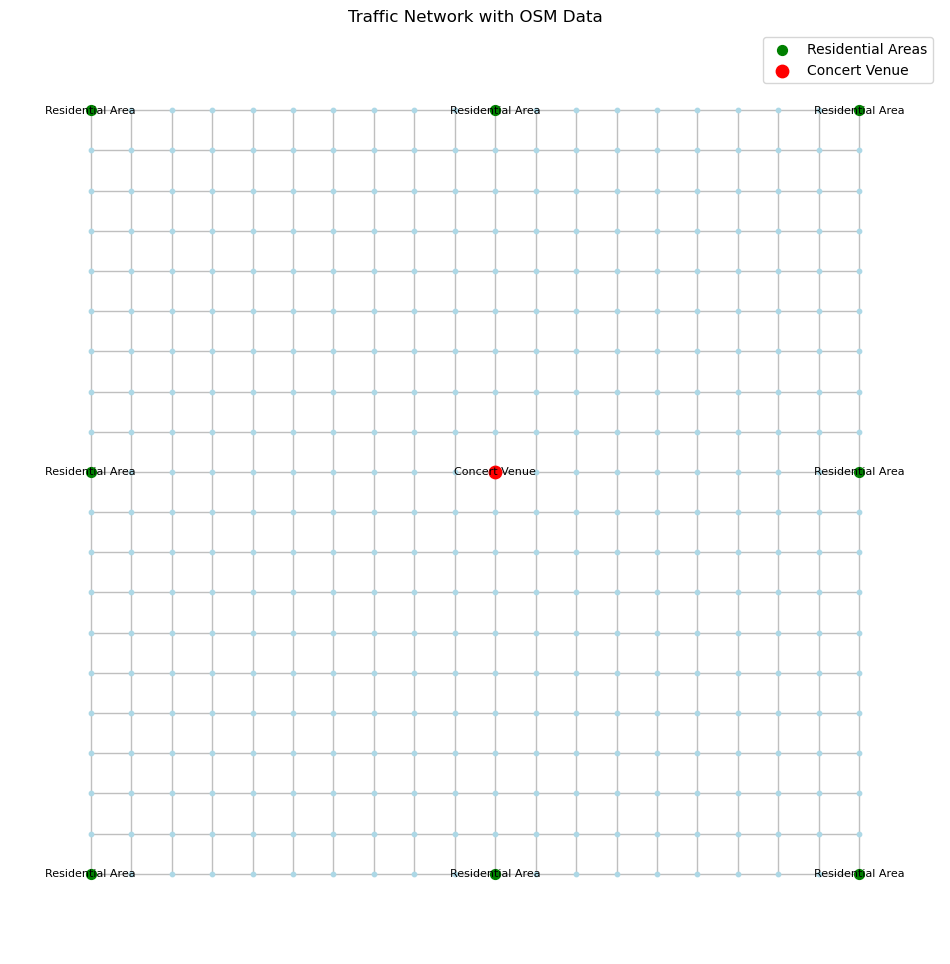

In [3]:
def plot_network_osm(G, concert_venue, residential_areas, title):
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(12, 12))

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

    # Draw nodes
    # Regular nodes
    regular_nodes = set(G.nodes()) - set(residential_areas) - {concert_venue}
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='lightblue', node_size=10)

    # Residential areas
    nx.draw_networkx_nodes(G, pos, nodelist=residential_areas, node_color='green', node_size=50, label='Residential Areas')

    # Concert venue
    nx.draw_networkx_nodes(G, pos, nodelist=[concert_venue], node_color='red', node_size=80, label='Concert Venue')

    # Optionally, draw labels for key nodes
    labels = {node: 'Concert Venue' if node == concert_venue else 'Residential Area' for node in residential_areas + [concert_venue]}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

# Plot the network with OSM data
plot_network_osm(model_with_event.G, model_with_event.event_venue, model_with_event.residential_areas, 'Traffic Network with OSM Data')


Language Learning Speaking Practice App